In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

In [5]:
data_path = Path("../scripts/data/csv_files")
save_path = Path("./output")
dfs = [pd.read_csv(f) for f in data_path.glob("*.csv")]

df = dfs[0]

In [6]:
from figure_utils import basic_event_iterator, collapse_2d, numpify_df

1279 719
4446607


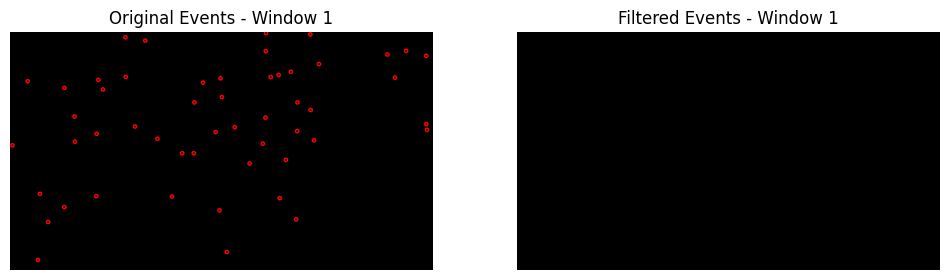

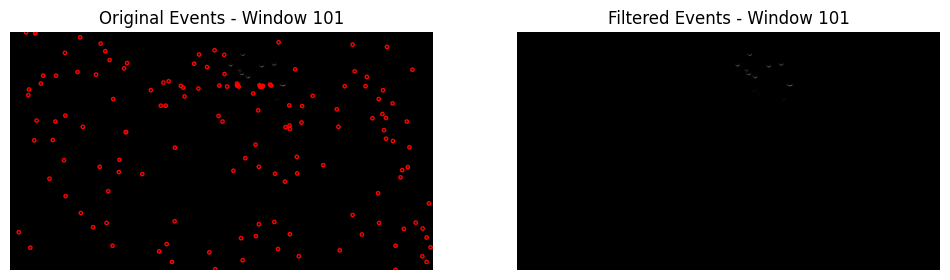

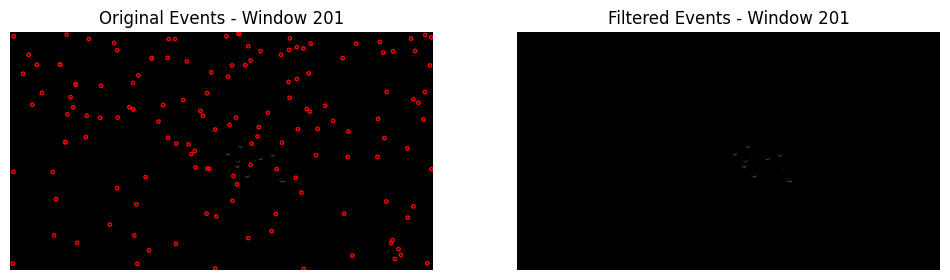

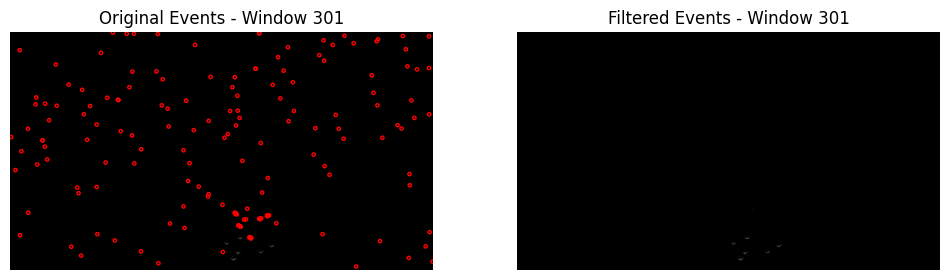

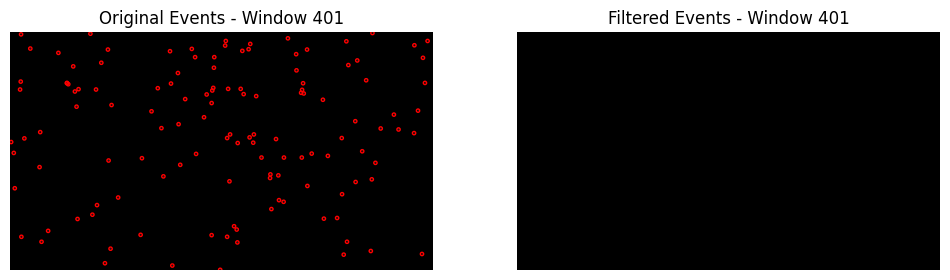

In [20]:
from eventcamprocessing import filter_funcs

events = numpify_df(df)

print(events["x"].max(), events["y"].max())
print(events["t"].max())

t_step = 10000  # in microseconds
t_window = 2000  # in microseconds
shape = (720, 1280)

output_stack = []

for i, window_events in enumerate(basic_event_iterator(events, t_step, t_window)):
    window_events = window_events[window_events["p"] == 1]

    # Original collapsed image
    img_original = collapse_2d(window_events, shape)

    # Filtered events
    filtered_events = filter_funcs.isolated_noise_filter(
        window_events, spatial_radius=20, time_window=500, min_neighbors=5
    )
    img_filtered = collapse_2d(filtered_events, shape)

    removed_events = [
        e for e in window_events.tolist() if e not in filtered_events.tolist()
    ]

    stacked = np.hstack((img_original, img_filtered))
    output_stack.append(stacked)

    if i % 100 != 0:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot original
    axes[0].imshow(img_original, cmap="gray")
    axes[0].set_title(f"Original Events - Window {i + 1}")
    axes[0].axis("off")

    # circle removed events
    for e in removed_events:
        circ = plt.Circle((e[0], e[1]), radius=5, color="red", fill=False, linewidth=1)
        axes[0].add_patch(circ)

    # Plot filtered
    axes[1].imshow(img_filtered, cmap="gray")
    axes[1].set_title(f"Filtered Events - Window {i + 1}")
    axes[1].axis("off")

    plt.show()

tifffile.imwrite(
    save_path / "filter_comparison.tiff",
    np.array(output_stack, dtype=np.uint8),
)